In [107]:
# Importing modules
import pandas as pd
import networkx as nx
import numpy as np
# Reading in datasets/book1.csv
book1 = pd.read_csv('book1.csv')
G_book1 = nx.Graph()
# Iterating through the DataFrame to add edges
for _, edge in book1.iterrows():
    G_book1.add_edge(edge['Source'], edge['Target'])
G = nx.Graph()
H=sorted(G_book1.nodes())
G.add_nodes_from(H)
G.add_edges_from(G_book1.edges())

books = [G]

### Common neighbor

In [108]:
def commonneighbor1(g,k):
    """Parameters
    
    g :  A NetworkX graph
  
    k : int
        the number of requested suggested links for each node
  
    """
    import networkx as nx
    ## calculate the adjacency matrix node 
    n_list = list(sorted(g.nodes))
    adj=nx.adjacency_matrix(g,nodelist=n_list)
    adj1 = adj.copy().todense().tolist()
    ## calculate common neighbors 
    cn=adj.T*adj.todense().tolist()
    ## define the output csv file
    cols_name = ['nodes']+[i for i in range(1,k+1)] 
    df=pd.DataFrame(columns=cols_name)
    i=0
    while i < len(cn):
    ## Get top k nodes using common neighbor
        cn_li = list(zip(n_list, cn[i], adj1[i]))
        cn_li.pop(i)
        cn_li = [(n[0], n[1]) for n in cn_li if n[2]==0]
        cn_li = sorted(cn_li, key = lambda x:(-x[1],x[0])) 
        cn_li = [node[0] for node in cn_li[:k]]
        ## list of node t and top k with most common neighbors
        simi = [n_list[i]] + cn_li
        ## add it to dataframe
        df.loc[len(df)]=simi 
        i+=1
    result_df = pd.DataFrame(df)
    result_df.to_csv("result-common1.csv", index=False) 

In [109]:
commonneighbor1(books[0],3)

### Preferential Attachment

In [110]:
def PreferentialAttachment(g,k):
    """Parameters
    
    g :  A NetworkX graph
  
    k : int
        the number of requested suggested links for each node
  
    """
    n_list = list(sorted(g.nodes))
    adj=nx.adjacency_matrix(g,nodelist=n_list).todense().tolist()
    ## read node by alphabetical order, calculate the adjacency matrix node 
    import numpy as np
    de=list(g.degree())
    l=[]
    j=0
    while j< g.number_of_nodes():
        num=de[j][1]
        l.append(num)
        j=j+1
    ## get the PA results
    l=np.matrix(l)
    #l1=np.array(l.copy())
    cn=l.T*l
    cn=np.array(cn)
    cn1=cn.copy()
    ## define the output csv file
    cols_name = ['nodes']+[i for i in range(1,k+1)] 
    df=pd.DataFrame(columns=cols_name)
    i=0
    while i< len(cn):
    ## filtered out the top k nodes using PA
        pa_li = list(zip(n_list, cn[i],adj[i]))
        pa_li.pop(i)
        pa_li = [(n[0], n[1]) for n in pa_li if n[2]==0]
        pa_li = sorted(pa_li, key = lambda x:(-x[1],x[0])) 
        pa_li = [node[0] for node in pa_li[:k]]
        ## list of node t and its top k nodes with highest PA score
        simi = [n_list[i]] + pa_li
        ## add it to dataframe
        df.loc[len(df)]=simi
        i+=1
    result_df = pd.DataFrame(df)
    result_df.to_csv("result-pa1.csv", index=False) 

In [111]:
PreferentialAttachment(books[0],3)

### Jaccard Index

In [112]:
def jac(g,k):
    """Parameters
    
    g :  A NetworkX graph
  
    k : int
        the number of requested suggested links for each node
  
    """
    ## calculate the adjacency matrix node 
    n_list = list(sorted(g.nodes))
    matrix=nx.adjacency_matrix(g,nodelist=n_list)
    adj1=matrix.todense().tolist()
    ## jaccard score
    sim = matrix * matrix
    sim1 = sim.copy().todense()                         
    sim1[ np.nonzero( sim1 ) ] = 1            
    deg_row = matrix.sum( axis = 0 )          
    deg_row_matrix = np.tile( deg_row, ( (matrix.shape)[0], 1) )
    deg_row_matrix = np.multiply( deg_row_matrix, sim1 )
    deg_row_matrix = np.triu( deg_row_matrix ) + np.triu( (deg_row_matrix.T) )
    sim = sim / ( np.multiply( deg_row_matrix, sim1 ) - sim ) 
    cn=sim.tolist()
    cn=pd.DataFrame(cn).fillna(0)
    cn=cn.values.tolist()
    ## define the output csv file
    cols_name = ['nodes']+[i for i in range(1,k+1)] 
    df=pd.DataFrame(columns=cols_name)
    i=0
    while i< len(cn):
    ## Get the top k nodes by Jaccard score
        jc_li = list(zip(n_list, cn[i], adj1[i]))
        jc_li.pop(i)
        jc_li = [(n[0], n[1]) for n in jc_li if n[2]==0]
        jc_li = sorted(jc_li, key = lambda x:(-x[1],x[0])) 
        jc_li = [node[0] for node in jc_li[:k]]
        ## list of node and its top k similar nodes with highest jaccard score
        simi = [n_list[i]] + jc_li
        ## add it to dataframe
        df.loc[len(df)]=simi
        i+=1
    result_df = pd.DataFrame(df)
    result_df.to_csv("result-jc1.csv", index=False) 

In [113]:
jac(books[0],3)

/Users/zihanfang/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


### Katz Similarity

In [114]:
def kaz(k,g,l,beta):
    """Parameters
    
    g :  A NetworkX graph
  
    k : int
        the number of requested suggested links for each node
        
    beta: float
        default is 0.85
    
    l: int
        path up to 3
        
    """
    n_list = list(sorted(g.nodes))
    ## calculate the adjacency matrix node 
    adj=nx.adjacency_matrix(g,nodelist=list(sorted(g.nodes))).todense().tolist()
    # Katz score
    from numpy.linalg import matrix_power
    
    ## use adjacency matrix to calculate the Katz Similarity
    kzs = []
    j=1
    while j <= l:
        kz = matrix_power(adj,j)*(beta**j)
        kzs.append(kz)
        j=j+1
    cn = sum(kzs).tolist()
    
    ## define the output csv file
    cols_name = ['nodes']+[i for i in range(1,k+1)] 
    df=pd.DataFrame(columns=cols_name)
    
    i=0
    while i< g.number_of_nodes():
    ## get the top k nodes by the Katz score
        kz_li = list(zip(n_list, cn[i],adj[i]))
        kz_li.pop(i)
        kz_li = [(n[0], n[1]) for n in kz_li if n[2]==0]
        kz_li = sorted(kz_li, key = lambda x:(-x[1],x[0])) 
        kz_li = [node[0] for node in kz_li[:k]]
        ## list of node and its top k nodes with highest katz score
        simi = [n_list[i]] + kz_li
        ## add it to dataframe
        df.loc[len(df)]=simi
        i+=1
    result_df = pd.DataFrame(df)
    result_df.to_csv("result-katz1.csv", index=False) 

In [115]:
kaz(k=3,g=books[0],l=3,beta=0.85)

## 2.

In [116]:
k=3
G=books[0]

In [117]:
# Implement ICM
def ICM(g,s,p): #function to implement Independent Cascade Model ICM
    import numpy as np
    just_activated = list(s) #just activates represent nodes that are activated in each iteration
    activated = list(s) #activated represents nodes that have been activated once 
    i=0
    while(1):
        if len(just_activated)==0: #If just activated = [], terminate the loop
            return activated
        i=i+1
        temp=[] # tempeorary list to hold the just_activated values and update them after each iteration
        for nodes in just_activated:
            for node in g.neighbors(nodes):
                r=np.random.uniform(0,1)
                if r<p and node not in activated and node not in temp:
                    #node once activated should not be used again
                    temp.append(node)
        for nodes in temp:
                activated.append(nodes)
        just_activated = list(temp) #update list after each iteration

        
def activated_nodes(List): #function to return list of activated nodes
    return [u for u in List]             

#### (A)

In [118]:
#(A)using the top k nodes according to their degree with the highest degree node being the top
from operator import itemgetter
import heapq
mapping = dict(zip(G, range(G.number_of_edges())))
dic_new = dict([val, key] for key, val in mapping.items())  
de=list(dict(G.degree()).values())
deind = list(map(de.index, heapq.nlargest(k,de)))
seeda= itemgetter(*deind)(dic_new)

In [119]:
seed = list(seeda) #Initial activated node list
p = 0.2 #Activation probability of nodes
i=0
expecta=[]

# simulate 10 rounds
while i < 10:
    active_nodes = activated_nodes(ICM(G,seed,p)) #return list of activated nodes
    expecta.append(len(active_nodes))
    i=i+1
from statistics import mean
mean(expecta)

89.2

#### (B)

In [120]:
#(B) using Betweeness Centrality with the highest k centrality being the top
bc=list(dict(nx.betweenness_centrality(G)).values())
bcind = list(map(bc.index, heapq.nlargest(k,bc)))
seedb= itemgetter(*bcind)(dic_new)

In [121]:
# simulate 10 rounds
seedb = list(seedb) #Initial activated node list
p = 0.2 #Activation probability of nodes
i=0
expectb=[]

# simulate 10 rounds
while i < 10:
    active_nodes = activated_nodes(ICM(G,seedb,p)) #return list of activated nodes
    expectb.append(len(active_nodes))
    i=i+1
mean(expectb)

88.6

In [122]:
#(C) randomly selected k nodes and simulate 10 rounds
i=0
p = 0.2
expectc=[]

# simulate 10 rounds
while i < 10:
    seedc = []
    nodes = list(set(G.nodes))
    np.random.shuffle(nodes)
    seedc =  nodes[:k]
    active_nodes = activated_nodes(ICM(G,seedc,p)) #return list of activated nodes
    expectc.append(len(active_nodes))
    i=i+1
mean(expectc)

84.1

In [55]:
# Read in the dataset (similar to what you did in Problem 1).
import operator
book1 = pd.read_csv('book1.csv')
G_book1 = nx.Graph()
# Iterating through the DataFrame to add edges
for _, edge in book1.iterrows():
    G_book1.add_edge(edge['Source'], edge['Target'])

G = nx.Graph()
H=sorted(G_book1.nodes())
G.add_nodes_from(H)
G.add_edges_from(G_book1.edges())

books = [G]

In [129]:
# Extract the adjacency matrix A.
A = nx.adjacency_matrix(books[0],nodelist=sorted(books[0].nodes())).astype('float').todense()

In [94]:
# Construct the vector k composed of all the node degrees
k = [val for (node, val) in books[0].degree()]
k = np.array(k, dtype=float)
import numpy as np
# degree matrix
D = np.diag(np.sum(np.array(A), axis=1))

In [88]:
# Extract/construct the Laplacian matrix L.
L = D - A
L

matrix([[2., 0., 0., ..., 0., 0., 0.],
        [0., 2., 0., ..., 0., 0., 0.],
        [0., 0., 7., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 4., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 7.]])

In [97]:
# Construct the matrix B using A, k, and the number of edges in the graph m.
import scipy.sparse.linalg
m=books[0].number_of_edges()
t=np.transpose(k)
B = A-((1/(2*m))*np.dot(k,t))

B

matrix([[-20.65643275, -20.65643275, -20.65643275, ..., -20.65643275,
         -20.65643275, -20.65643275],
        [-20.65643275, -20.65643275, -20.65643275, ..., -20.65643275,
         -20.65643275, -20.65643275],
        [-20.65643275, -20.65643275, -20.65643275, ..., -20.65643275,
         -20.65643275, -20.65643275],
        ...,
        [-20.65643275, -20.65643275, -20.65643275, ..., -20.65643275,
         -20.65643275, -20.65643275],
        [-20.65643275, -20.65643275, -20.65643275, ..., -20.65643275,
         -20.65643275, -20.65643275],
        [-20.65643275, -20.65643275, -20.65643275, ..., -20.65643275,
         -20.65643275, -20.65643275]])

In [98]:
# Extract out the largest eigenvalue/vector pair
eigval1,eigvec1=scipy.sparse.linalg.eigs(B, k=1,which='LR')

In [127]:
print(eigval1)
print(eigvec1)

[13.76874765+0.j]
[[ 1.93343624e-02+0.j]
 [ 2.97389053e-02+0.j]
 [ 5.51260373e-02+0.j]
 [-1.61594401e-02+0.j]
 [ 7.95573786e-02+0.j]
 [ 4.41286745e-02+0.j]
 [ 5.37449311e-02+0.j]
 [-4.23516008e-03+0.j]
 [ 4.22494483e-02+0.j]
 [-1.70141688e-01+0.j]
 [ 2.43630625e-02+0.j]
 [ 6.34559093e-03+0.j]
 [ 1.91528962e-02+0.j]
 [-1.34218637e-01+0.j]
 [-4.39404538e-02+0.j]
 [-2.26507491e-02+0.j]
 [-2.52397530e-02+0.j]
 [ 4.90736234e-02+0.j]
 [-1.61423449e-01+0.j]
 [-9.72905372e-03+0.j]
 [ 1.25905189e-02+0.j]
 [-2.18076109e-02+0.j]
 [-1.56004060e-01+0.j]
 [ 9.14189314e-03+0.j]
 [-2.34964167e-01+0.j]
 [ 2.92235075e-02+0.j]
 [ 4.39547677e-02+0.j]
 [ 3.11516576e-02+0.j]
 [ 4.45784531e-02+0.j]
 [ 4.54318054e-02+0.j]
 [ 6.83897465e-02+0.j]
 [ 3.14557101e-02+0.j]
 [ 3.54339526e-02+0.j]
 [ 4.40016038e-02+0.j]
 [ 8.71713549e-02+0.j]
 [ 4.93346379e-02+0.j]
 [ 3.54685551e-02+0.j]
 [ 2.44978320e-02+0.j]
 [ 1.10507102e-02+0.j]
 [ 4.44427837e-02+0.j]
 [ 3.54685551e-02+0.j]
 [ 3.00977966e-02+0.j]
 [ 7.94000696e-0

In [99]:
# Extract out the second smallest eigenvalue/vector pair 
eigval2,eigvec2 = scipy.sparse.linalg.eigs(L,k=2,which='SR')
eigval2=eigval2[1]
eigvec2=eigvec2[:,1]

In [126]:
print(eigval2)
print(eigvec2)

(0.23227352209672877+0j)
[-3.29315583e-03+0.j -1.85830107e-02+0.j -8.42920636e-03+0.j
 -7.91269749e-03+0.j -3.07529802e-02+0.j -8.27322457e-03+0.j
 -7.78419539e-03+0.j -7.40011751e-03+0.j -1.42832440e-02+0.j
 -6.19700527e-03+0.j -8.04871038e-03+0.j -8.93911667e-03+0.j
 -7.35144398e-03+0.j -6.66242479e-03+0.j -5.94890144e-03+0.j
 -8.06363008e-03+0.j -6.80827854e-03+0.j -8.01557130e-03+0.j
 -5.11593131e-03+0.j -7.81722487e-03+0.j -4.22023259e-03+0.j
  5.36645463e-03+0.j -3.89789722e-04+0.j -7.35926170e-03+0.j
 -6.17920807e-03+0.j -6.94920491e-03+0.j -8.26470716e-03+0.j
 -4.91883200e-03+0.j -7.03901581e-03+0.j -1.09794394e-02+0.j
 -3.18074969e-02+0.j -2.06616827e-03+0.j -9.42192342e-03+0.j
 -1.22725003e-02+0.j -2.57103642e-02+0.j  4.66477974e-01+0.j
 -8.74727222e-03+0.j -7.39201224e-03+0.j -7.54433525e-03+0.j
 -1.10322078e-02+0.j -8.74727222e-03+0.j -5.07719524e-04+0.j
 -2.88942366e-02+0.j -3.15478721e-02+0.j -8.74727222e-03+0.j
 -7.13931590e-03+0.j -3.15292557e-03+0.j -2.77597176e-03+0.j

In [100]:
# Create an output file for modularity maximization that has two rows of output that are comma separated
mapping = dict(zip(books[0], range(books[0].number_of_edges())))
dic_new = dict([val, key] for key, val in mapping.items())  
result=[]
lm=np.array(eigvec1>=0)
keys=np.where(lm == True)[0]
#out = operator.itemgetter(*keys)(dic_new)
result.append(keys)
ls=np.array(eigvec1<0)
keys1=np.where(ls == True)[0]
#out1 = operator.itemgetter(*keys1)(dic_new)
result.append(keys1)
result_df = pd.DataFrame(result)
result_df.to_csv("result-maxmodularity.csv", index=False) 

In [101]:
# Create an output file for min graph cut that has two rows of output that are comma separated
results=[] 
lm1=np.array(eigvec2>=0)
keys2=np.where(lm1 == True)[0]

results.append(keys2)
ls1=np.array(eigvec2<0)
keys3=np.where(ls1 == True)[0]

results.append(keys3)
result_df1 = pd.DataFrame(results)
result_df1.to_csv("result-mincut.csv", index=False) 

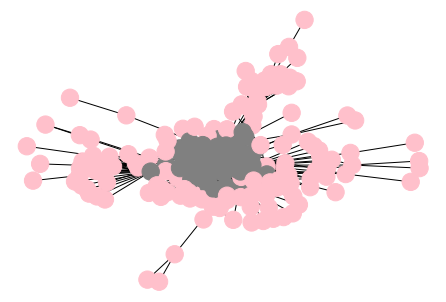

In [106]:
color_map=[]
for node in nx.convert_node_labels_to_integers(books[0]).nodes():
    if node in result[0]:
        color_map.append('pink')
    else: 
        color_map.append('grey') 
# Draw the graph based on the modularity maximization clustering output
nx.draw(books[0],node_color=color_map, nodesize=50, fontsize=2)

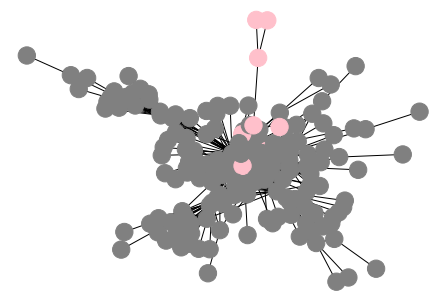

In [105]:
# Draw the graph based on the min graph cut clustering output
color_map1=[]
for node in nx.convert_node_labels_to_integers(books[0]).nodes():
    if node in results[0]:
        color_map1.append('pink')
    else: 
        color_map1.append('grey') 
nx.draw(books[0], node_color=color_map1, nodesize=50, fontsize=1)